In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#import sys
#!{sys.executable} -m pip install sagemaker -U
#!{sys.executable} -m pip install sagemaker-experiments

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import os
import sys
import time
import json
from IPython.display import display
from time import strftime, gmtime
import boto3
import re
from datetime import datetime

import sagemaker
from sagemaker import get_execution_role
from sagemaker.predictor import csv_serializer
from sagemaker.debugger import rule_configs, Rule, DebuggerHookConfig
from sagemaker.model_monitor import DataCaptureConfig, DatasetFormat, DefaultModelMonitor
from sagemaker.s3 import S3Uploader, S3Downloader

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

%cd /root/predicting-coronavirus
%pip install mpu
import src.data_import as di

%matplotlib inline
pd.set_option('display.max_columns', 500)  
pd.set_option('display.max_rows', 500)   

/root/predicting-coronavirus
Note: you may need to restart the kernel to use updated packages.


In [5]:
sess = boto3.Session()
sm = sess.client('sagemaker')
role = sagemaker.get_execution_role()

In [6]:
!cd data/covid-19-data;git pull origin master

remote: Enumerating objects: 5, done.
remote: Counting objects: 100% (5/5), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0
Unpacking objects: 100% (5/5), done.
From https://github.com/nytimes/covid-19-data
 * branch            master     -> FETCH_HEAD
   d89108a..b761184  master     -> origin/master
Updating d89108a..b761184
Fast-forward
 us-counties.csv | 3795 ++++++++++++++++++++++++++++++++++++++++++++++++-------
 us-states.csv   |  221 ++--
 us.csv          |   65 +-
 3 files changed, 3524 insertions(+), 557 deletions(-)


In [7]:
account_id = sess.client('sts', region_name=sess.region_name).get_caller_identity()["Account"]
bucket = 'sagemaker-studio-{}-{}'.format(sess.region_name, account_id)
prefix = 'capstone2'

try:
    if sess.region_name == "us-east-1":
        sess.client('s3').create_bucket(Bucket=bucket)
    else:
        sess.client('s3').create_bucket(Bucket=bucket, 
                                        CreateBucketConfiguration={'LocationConstraint': sess.region_name})
except Exception as e:
    print("Looks like you already have a bucket of this name. That's good. Uploading the data files...")

# Return the URLs of the uploaded file, so they can be reviewed or used elsewhere
s3url = S3Uploader.upload('data/covid-19-data/us-counties.csv', 's3://{}/{}/{}'.format(bucket, prefix,'nyt'))
print(s3url)


s3://sagemaker-studio-us-east-1-752222400982/capstone2/nyt/us-counties.csv


In [8]:
nyt_df = di.extract_nyt()

In [9]:
nyt_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134025 entries, 0 to 135569
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    134025 non-null  datetime64[ns]
 1   county  134025 non-null  object        
 2   state   134025 non-null  object        
 3   fips    134025 non-null  int64         
 4   cases   134025 non-null  int64         
 5   deaths  134025 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 7.2+ MB


In [10]:
#Get the maximum cases and deaths for each fips
max_cases = nyt_df.groupby('fips').max()
max_cases = max_cases[['cases', 'deaths']]
#max_cases['deaths'].sum()
#max_cases

In [41]:
hhi = di.extract_hhi()
edu = di.extract_edu()
sip = di.extract_sip()
pubtrans = di.extract_public_transport()
housing = di.extract_housing()
election = di.extract_election()
geo = di.extract_geography()

/root/predicting-coronavirus/src/data_import.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ret['hs'] = ret['hs']/100
/root/predicting-coronavirus/src/data_import.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ret['ba_plus'] = ret['ba_plus']/100
/root/predicting-coronavirus/src/data_import.py:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

<class 'pandas.core.series.Series'>


In [42]:
geo.head()

,sc,fips,state,county,population,area-km
0,Alabama:Autauga,1001,Alabama,Autauga,54571,1539.582
1,Alabama:Baldwin,1003,Alabama,Baldwin,182265,4117.522
2,Alabama:Barbour,1005,Alabama,Barbour,27457,2291.819
3,Alabama:Bibb,1007,Alabama,Bibb,22915,1612.481
4,Alabama:Blount,1009,Alabama,Blount,57322,1669.962


In [ ]:
per100k = pd.merge(geo, nyt_df, how='inner', left_on=['fips'], right_on=['fips'])
per100k = per100k[['fips', 'population', 'date', 'cases', 'deaths']]
per100k['deaths_per'] = per100k.apply(lambda row: (row['deaths']/row['population'])*100000, axis=1)
per100k['cases_per'] = per100k.apply(lambda row: (row['cases']/row['population'])*100000, axis=1)


In [86]:
ten = per100k[per100k['cases_per'] > 10].groupby('fips').min()
ten = ten[['date']]
ten.columns = ['date_10']
#ten['date_10'].fillna(datetime(2020,5,15))

In [161]:
big_df = pd.merge(geo, hhi, how='inner', left_on=['fips'], right_on=['fips'])
big_df = pd.merge(big_df, edu, how='inner', left_on=['fips'], right_on=['fips'])
big_df = pd.merge(big_df, housing, how='inner', left_on=['fips'], right_on=['fips'])
big_df = pd.merge(big_df, pubtrans, how='inner', left_on=['fips'], right_on=['fips'])
big_df = pd.merge(big_df, election, how='left', left_on=['fips'], right_on=['fips'])
big_df = pd.merge(big_df, sip, how='left', left_on=['state'], right_on=['state'])

big_df = pd.merge(big_df, max_cases, how='left', left_on=['fips'], right_on=['fips'])
big_df = pd.merge(big_df, ten, how='left', left_on=['fips'], right_on=['fips'])


In [162]:
big_df

,sc,fips,state,county,population,area-km,households,mean_hhi,median_hhi,pop_over_25,hs,ba_plus,ma_plus,pop_over_65,median_house_price,median_rent,percent_big_buildings,percent_commuter,per_dem,per_gop,sip,sip_lifted,cases,deaths,date_10
0,Alabama:Baldwin,1003,Alabama,Baldwin,182265,4117.522,83501,56813,80251,155691,0.283,0.207,0.107,44443,193800,1057,0.141,0.0,0.195653,0.773515,2020-04-03,2020-04-30,224.0,6.0,2020-03-31
1,Alabama:Calhoun,1015,Alabama,Calhoun,118572,1569.190,44264,45818,61117,79172,0.325,0.100,0.080,20515,121800,743,0.020,0.7,0.278559,0.692397,2020-04-03,2020-04-30,125.0,3.0,2020-04-02
2,Alabama:Cullman,1043,Alabama,Cullman,80406,1903.228,30323,44612,67585,58319,0.311,0.084,0.037,15541,127700,710,0.008,0.0,0.100059,0.878105,2020-04-03,2020-04-30,65.0,1.0,2020-04-01
3,Alabama:DeKalb,1049,Alabama,DeKalb,71109,2012.662,26462,36998,57354,48169,0.298,0.082,0.067,12261,112000,670,0.000,0.0,0.141149,0.834892,2020-04-03,2020-04-30,158.0,2.0,2020-04-02
4,Alabama:Elmore,1051,Alabama,Elmore,79303,1601.868,30155,60796,70961,56793,0.325,0.179,0.074,12299,166300,837,0.002,0.0,0.228587,0.748381,2020-04-03,2020-04-30,152.0,4.0,2020-03-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
822,Wisconsin:Waukesha,55133,Wisconsin,Waukesha,389891,1423.389,158368,86968,115491,284512,0.221,0.295,0.161,75079,290500,1029,0.096,0.5,0.339516,0.610962,2020-03-24,2020-05-26,409.0,23.0,2020-03-25
823,Wisconsin:Winnebago,55139,Wisconsin,Winnebago,166994,1125.316,71332,56589,75157,115949,0.326,0.183,0.069,27997,149200,735,0.067,0.5,0.431402,0.505833,2020-03-24,2020-05-26,100.0,1.0,2020-04-02
824,Wisconsin:Wood,55141,Wisconsin,Wood,74749,2054.162,32274,55273,69755,52200,0.386,0.146,0.080,14940,129400,743,0.049,0.0,0.377387,0.570163,2020-03-24,2020-05-26,4.0,0.0,NaT
825,Wyoming:Laramie,56021,Wyoming,Laramie,91738,6956.480,39678,64306,84033,68017,0.286,0.177,0.087,16163,246500,893,0.058,0.0,0.289698,0.621955,2020-05-15,2020-05-15,166.0,1.0,2020-03-25


In [163]:
def days_since(row):
    row['days_since_sip'] = int((datetime(2020,5,15) - row['sip']).days)
    lifted = int((datetime(2020,5,15) - row['sip_lifted']).days)
    if(lifted < 0):
        lifted = 0
    row['days_since_sip_lifted'] = lifted
    ten_per = row['date_10']
    if pd.isnull(ten_per):
        row['days_since_10p100k'] = 0
    else:
        row['days_since_10p100k'] = int((datetime(2020,5,15) - ten_per).days)
    return row

big_df['percent_over_65'] = big_df['pop_over_65']/big_df['population']
big_df['percent_over_25'] = big_df['pop_over_25']/big_df['population']
big_df['pop_density'] = big_df['population']/big_df['area-km']
big_df['hh_density'] = big_df['households']/big_df['area-km']
big_df['case_rate'] = big_df['cases']/big_df['population']*100000
big_df['death_rate'] = big_df['deaths']/big_df['population']*100000
big_df['case_rate'] = big_df['case_rate'].fillna(0)
big_df['death_rate'] = big_df['death_rate'].fillna(0)
big_df = big_df.apply(days_since, axis=1)



clean_df = big_df.drop(['pop_over_65', 'pop_over_25', 'population', 'households','area-km', 'cases', 'deaths', 'sip', 'sip_lifted', 'date_10'], axis=1)



In [138]:
clean_df.corr()

,fips,mean_hhi,median_hhi,hs,ba_plus,ma_plus,median_house_price,median_rent,percent_big_buildings,percent_commuter,per_dem,per_gop,percent_over_65,percent_over_25,pop_density,hh_density,case_rate,death_rate,days_since_sip,days_since_sip_lifted,days_since_10p100k
fips,1.000000,0.000697,-0.035591,0.096975,0.008538,-0.015774,-0.144160,-0.134738,-0.021316,0.010283,-0.093986,0.079528,-0.067798,-0.034402,0.022569,0.021840,-0.016166,-0.045921,0.053568,-0.058162,-0.080523
mean_hhi,0.000697,1.000000,0.957637,-0.563993,0.731685,0.623338,0.725882,0.805140,0.242787,0.263177,0.235878,-0.261395,-0.109348,0.351034,0.120189,0.121180,0.224255,0.249132,0.146676,-0.235241,0.289936
median_hhi,-0.035591,0.957637,1.000000,-0.631483,0.778678,0.707615,0.787518,0.834240,0.366607,0.355383,0.338003,-0.350217,-0.085456,0.359457,0.216656,0.219586,0.270954,0.309814,0.136301,-0.223175,0.312739
hs,0.096975,-0.563993,-0.631483,1.000000,-0.778131,-0.728034,-0.606487,-0.625950,-0.432340,-0.274501,-0.486575,0.530009,0.177823,-0.220370,-0.171010,-0.175113,-0.062566,-0.071649,-0.033015,0.056554,-0.262582
ba_plus,0.008538,0.731685,0.778678,-0.778131,1.000000,0.796044,0.599789,0.632958,0.444584,0.284157,0.406817,-0.441989,-0.112633,0.331604,0.183107,0.187267,0.121737,0.166023,-0.021178,-0.102118,0.302281
ma_plus,-0.015774,0.623338,0.707615,-0.728034,0.796044,1.000000,0.574783,0.594262,0.460636,0.394371,0.539003,-0.555314,-0.090934,0.155445,0.230143,0.238198,0.203545,0.249723,0.081351,-0.163553,0.311535
median_house_price,-0.144160,0.725882,0.787518,-0.606487,0.599789,0.574783,1.000000,0.871845,0.514615,0.525053,0.476013,-0.499642,0.004046,0.331032,0.387655,0.382628,0.186578,0.193936,0.199192,-0.254123,0.174075
median_rent,-0.134738,0.805140,0.834240,-0.625950,0.632958,0.594262,0.871845,1.000000,0.451292,0.429643,0.490613,-0.496950,-0.056588,0.375713,0.267747,0.259162,0.254494,0.257914,0.183183,-0.178161,0.272603
percent_big_buildings,-0.021316,0.242787,0.366607,-0.432340,0.444584,0.460636,0.514615,0.451292,1.000000,0.743965,0.560294,-0.557923,-0.136987,0.152910,0.700260,0.693758,0.248408,0.220059,-0.019080,-0.127970,-0.010787
percent_commuter,0.010283,0.263177,0.355383,-0.274501,0.284157,0.394371,0.525053,0.429643,0.743965,1.000000,0.516960,-0.498620,-0.138662,0.047619,0.837653,0.800654,0.475591,0.481874,0.137719,-0.223692,-0.134982


In [198]:
big_df[big_df['pop_density']>10000]

,sc,fips,state,county,population,area-km,households,mean_hhi,median_hhi,pop_over_25,hs,ba_plus,ma_plus,pop_over_65,median_house_price,median_rent,percent_big_buildings,percent_commuter,per_dem,per_gop,sip,sip_lifted,cases,deaths,date_10,percent_over_65,percent_over_25,pop_density,hh_density,case_rate,death_rate,days_since_sip,days_since_sip_lifted,days_since_10p100k
447,New York:Bronx,36005,New York,Bronx,1385108,109.029,507370,38467,57617,934391,0.277,0.134,0.073,183165,436100,1188,0.634,58.4,0.887270,0.095927,2020-03-20,2020-05-15,NaN,NaN,NaT,0.132239,0.674598,12704.032872,4653.532546,0.0,0.0,56,0,0
457,New York:Kings,36047,New York,Kings,2504700,183.412,969317,61220,92542,1785323,0.258,0.233,0.156,358797,759400,1433,0.358,60.7,0.797387,0.179089,2020-03-20,2020-05-15,NaN,NaN,NaT,0.143249,0.712789,13656.140274,5284.915927,0.0,0.0,56,0,0
462,New York:New York,36061,New York,New York,1585873,59.126,752258,85066,156633,1249838,0.131,0.321,0.292,268834,1013400,1746,0.785,59.9,0.871676,0.099659,2020-03-20,2020-05-15,NaN,NaN,NaT,0.169518,0.788107,26821.922674,12722.964516,0.0,0.0,56,0,0


In [164]:
y = clean_df['case_rate']

In [226]:
X['days_since_sip'].describe()

count    827.000000
mean      47.690447
std       10.543738
min        0.000000
25%       44.000000
50%       49.000000
75%       54.000000
max       57.000000
Name: days_since_sip, dtype: float64

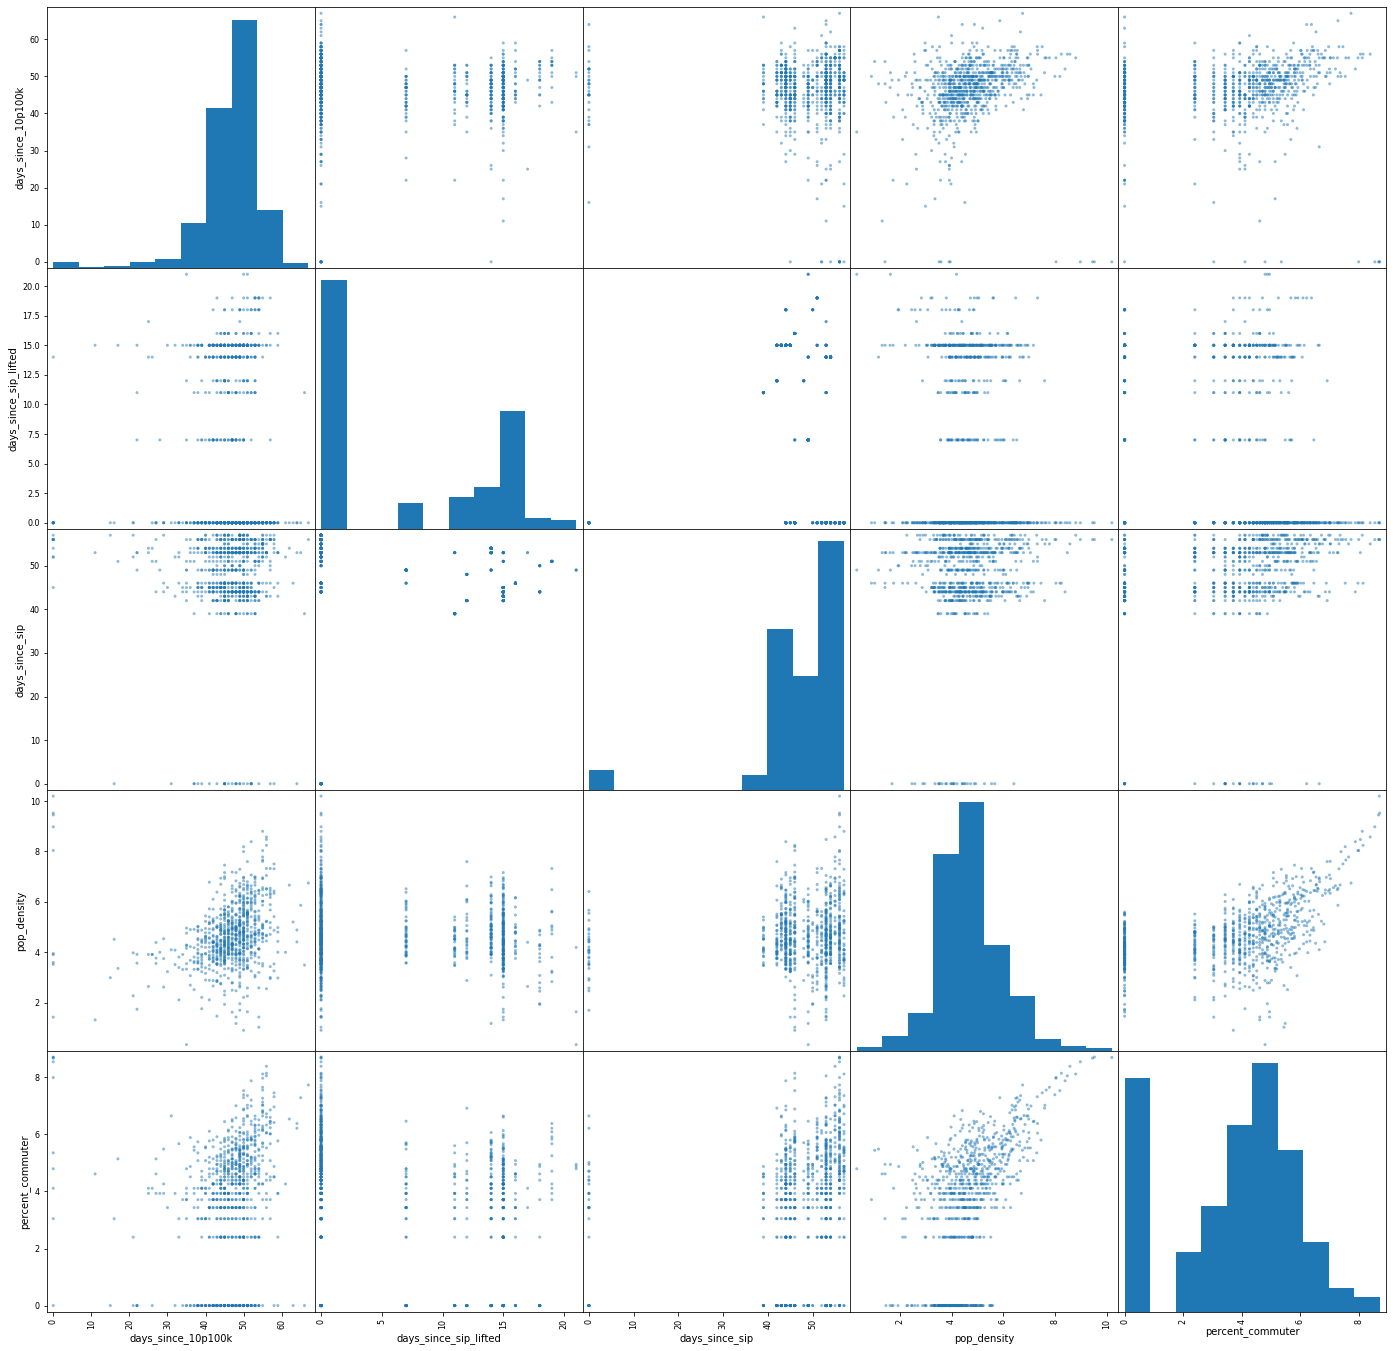

In [223]:
X = clean_df.drop(['case_rate', 'death_rate', 'sc', 'state', 'county'], axis=1).set_index('fips')
X = X[['days_since_10p100k', 'days_since_sip_lifted', 'days_since_sip', 'pop_density', 'percent_commuter']]
#X = X[['pop_density']
#per100k['cases_per'] = per100k.apply(lambda row: (row['cases']/row['population'])*100000, axis=1)

#X['days_since_sip'] = X.apply(lambda x: np.log(x['days_since_sip']*100+1), axis=1)
X['percent_commuter'] = X.apply(lambda x: np.log(x['percent_commuter']*100+1), axis=1)
X['pop_density'] = X.apply(lambda x: np.log(x['pop_density']), axis=1)
xxx = pd.plotting.scatter_matrix(X, figsize=(24,24))

In [195]:
X.describe()

,pop_density,percent_commuter
count,827.000000,827.000000
mean,310.514600,2.102056
std,1262.104736,5.538989
min,1.396347,0.000000
25%,51.393694,0.100000
50%,97.232984,0.700000
75%,207.641479,1.800000
max,26821.922674,60.700000


Mean cross-validation score: 0.14


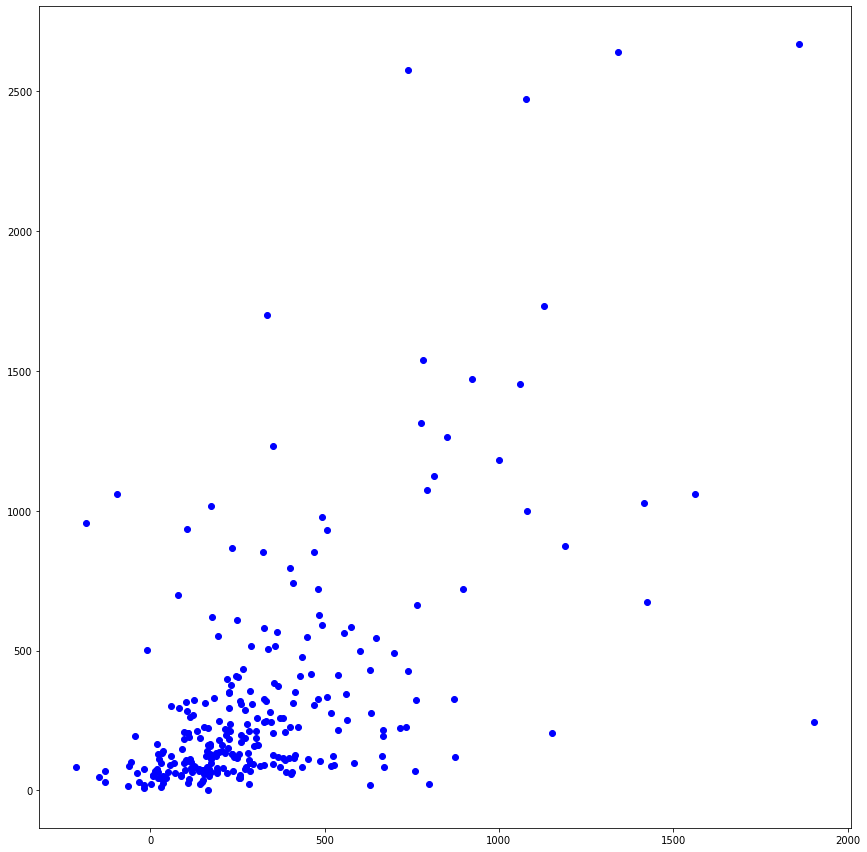

In [238]:
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
poly.fit(X_train_poly, y_train)
lin = LinearRegression()
lin.fit(X_train_poly, y_train)
X_test_poly = poly.fit_transform(X_test)
predicted = lin.predict(X_test_poly)

fig, ax = plt.subplots(figsize=(12,12))
fig.tight_layout()
plt.scatter(predicted, y_test, color = 'blue', label="actual data") 
#lin.score(X_train_poly, y_train)
#lin.score(X_test_poly, y_test)
scores = cross_val_score(lin, X_train,y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())

In [230]:
%pip install xgboost
import xgboost as xgb

In [231]:
xgbr = xgb.XGBRegressor() 
print(xgbr)

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=None, gamma=None,
             gpu_id=None, importance_type='gain', interaction_constraints=None,
             learning_rate=None, max_delta_step=None, max_depth=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             objective='reg:squarederror', random_state=None, reg_alpha=None,
             reg_lambda=None, scale_pos_weight=None, subsample=None,
             tree_method=None, validate_parameters=False, verbosity=None)


In [232]:
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

Mean cross-validation score: 0.26


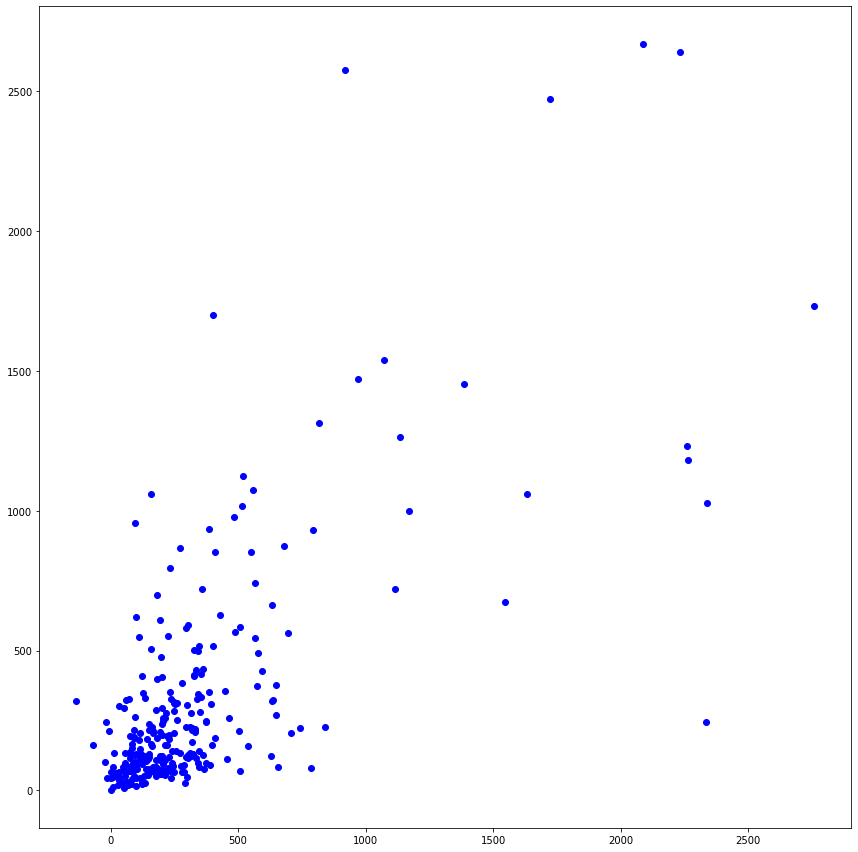

In [239]:
predicted = xgbr.predict(X_test)
fig, ax = plt.subplots(figsize=(12,12))
fig.tight_layout()
plt.scatter(predicted, y_test, color = 'blue', label="actual data") 
#lin.score(X_train_poly, y_train)
#lin.score(X_test_poly, y_test)
scores = cross_val_score(xgbr, X_train, y_train, cv=5)

print("Mean cross-validation score: %.2f" % scores.mean())